<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#explore-data" data-toc-modified-id="explore-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>explore data</a></span></li><li><span><a href="#processed-data" data-toc-modified-id="processed-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>processed data</a></span></li><li><span><a href="#build-model-1:-decision-tree" data-toc-modified-id="build-model-1:-decision-tree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>build model 1: decision tree</a></span></li><li><span><a href="#build-random-forest" data-toc-modified-id="build-random-forest-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>build random forest</a></span></li><li><span><a href="#visualize-decision-surface" data-toc-modified-id="visualize-decision-surface-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>visualize decision surface</a></span></li><li><span><a href="#to-do" data-toc-modified-id="to-do-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>to do</a></span></li></ul></div>

# wine quality prediction based on chemical properties

- predict the quality of a wine based on the chemical properties of the wine.
- dataset: wine quality dataset hosted on the <a href="https://archive.ics.uci.edu/ml/datasets/Wine+Quality">UCI website</a>. 
- barplot analyze quality dependence on chemicals.

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score

##  Data preparation

Import data

In [3]:
df = pd.read_csv('winequality-red.csv',sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


total 1599. no NaN object.

- features: all columns except quality.
- target: quality
- classified quality into bad $(score<7)$ or good $(score>7)$ into 0 or 1.

## explore data

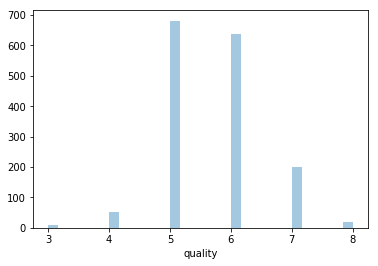

In [12]:
# how does the quality distributed?
sns.distplot(df.quality,kde=False)

almost gaussian-like. with most quality at 5.

In [88]:
list_features = df.columns.tolist()
list_features[:-1]

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

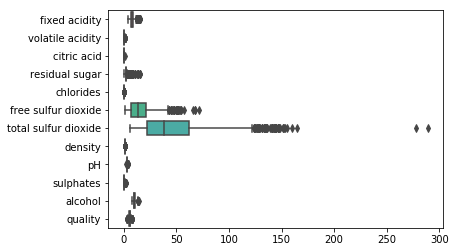

In [191]:
# univariate 
sns.boxplot(data=df,orient='h')

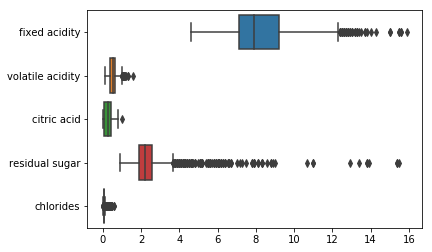

In [195]:
sns.boxplot(data=df.iloc[:,0:5],orient='h')

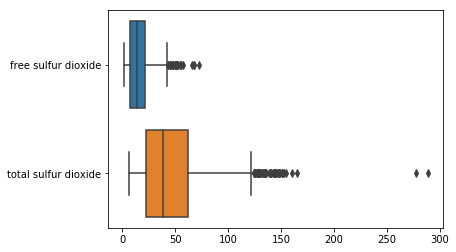

In [197]:
sns.boxplot(data=df.iloc[:,5:7],orient='h')

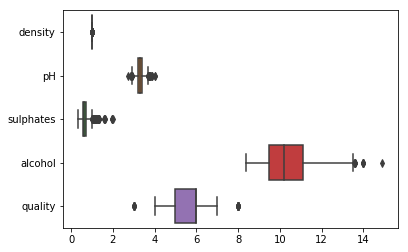

In [198]:
sns.boxplot(data=df.iloc[:,7:],orient='h')

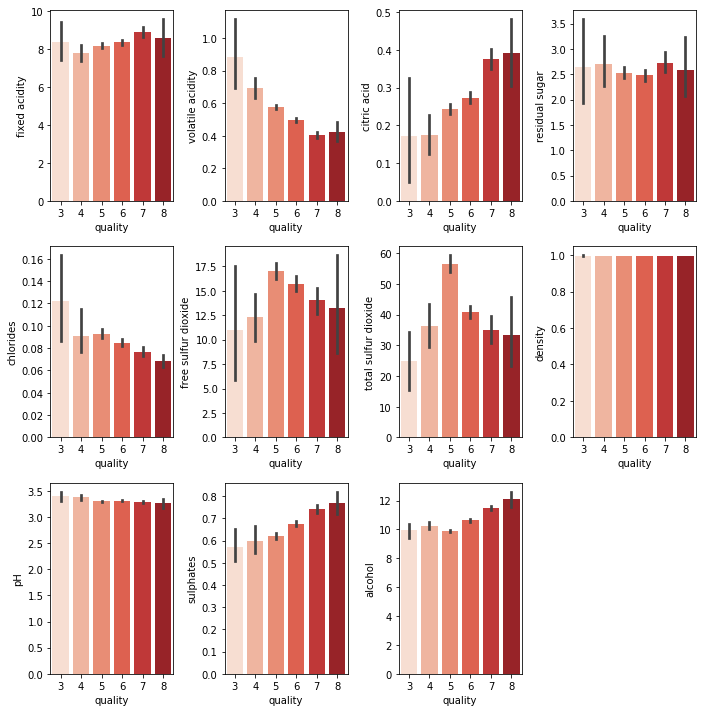

In [50]:
# how the quality related to features?
j=0
plt.figure(figsize=(10,10))
for i in list_features[:-1]:
    j+=1
    plt.subplot(3, 4,j )

    sns.barplot(x='quality',y=i,palette='Reds',data=df)

plt.tight_layout()
plt.savefig('./figures/features.png')

we can see that there are correlations of quality with these features: 'volatile acidity',
 'citric acid',
 'chlorides',
 'pH',
 'sulphates',
 'alcohol'

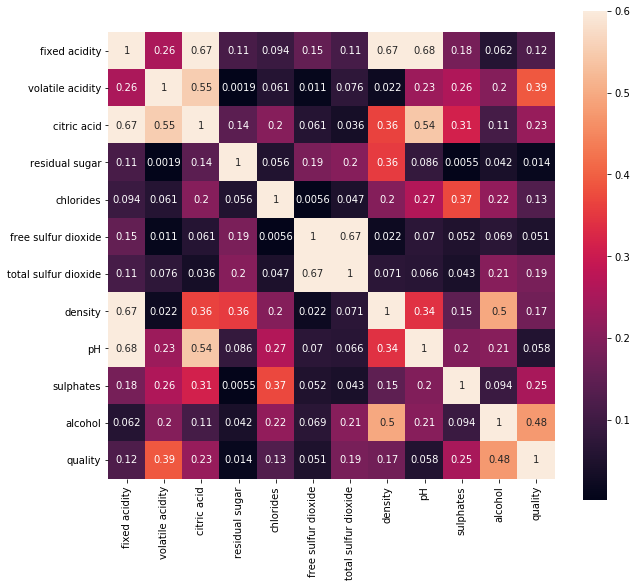

In [104]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(abs(corrmat), vmax=0.6, square=True,annot=True)
plt.savefig('./figures/corrmat.png')

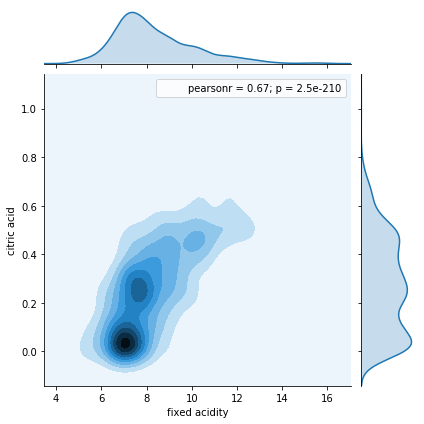

In [110]:
sns.jointplot(x='fixed acidity', y="citric acid", data=df, kind="kde");

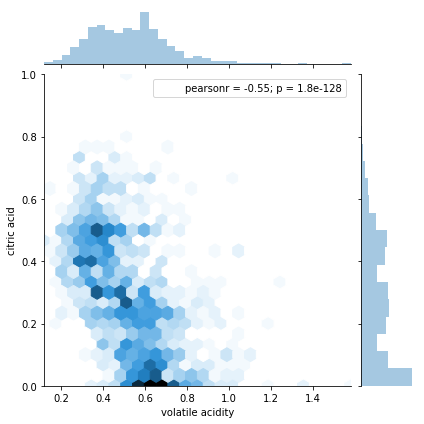

In [105]:
sns.jointplot(x='volatile acidity', y="citric acid", data=df, kind="hex");

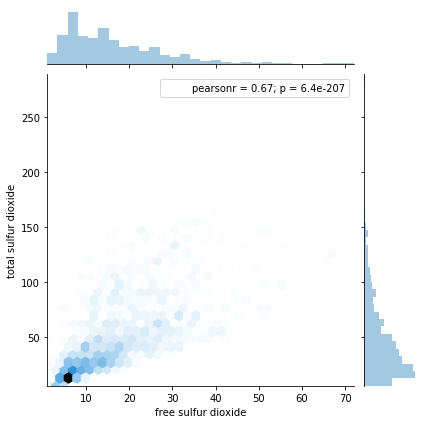

In [109]:
sns.jointplot(x='free sulfur dioxide', y="total sulfur dioxide", data=df, kind="hex");

## processed data
- I binarized the quality into two group, quality <5 as bad and quality >=6 as good.
- apply standard scaler
- split into train and test set

In [236]:

Y = df.quality.values
dfx = df.drop(['quality'],1)
Y = np.array([1 if y>=7 else 0 for y in Y])

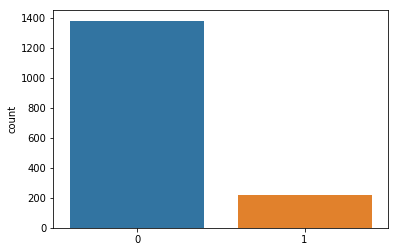

In [237]:
sns.countplot(Y)

In [238]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(dfx)

In [239]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2, random_state = 42)

In [240]:
dfx.shape

(1599, 11)

## build model 1: decision tree

In [241]:
# identifying the most important factors.
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report

tree_clf=DecisionTreeClassifier()
cross_val_score(tree_clf,X_train,y_train)

array([0.86651054, 0.86885246, 0.86117647])

In [242]:
tree_clf.fit(X_train,y_train)
pred_tree_clf = tree_clf.predict(X_test)
print(classification_report(y_test, pred_tree_clf))

             precision    recall  f1-score   support

          0       0.92      0.94      0.93       273
          1       0.60      0.53      0.56        47

avg / total       0.87      0.88      0.88       320



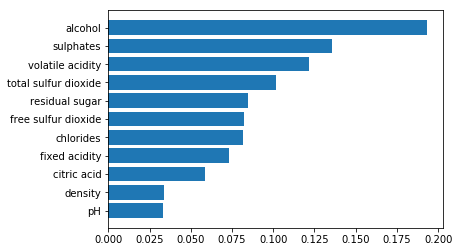

In [243]:
list_importance = tree_clf.feature_importances_
list_name = dfx.columns
list_importance, list_name = zip(*sorted(zip(list_importance, list_name)))
plt.barh(range(len(list_importance)),list_importance)
plt.yticks(range(len(list_name)),list_name)
plt.show()

## build random forest
- varying number of trees
- use 10-fold cross-validation.

In [227]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import classification_report

In [228]:
random_clf = RandomForestClassifier(n_estimators=200)
random_clf.fit(X_train, y_train)
pred_random_clf = random_clf.predict(X_test)
print(classification_report(y_test, pred_random_clf))

             precision    recall  f1-score   support

          0       0.92      0.96      0.94       273
          1       0.71      0.53      0.61        47

avg / total       0.89      0.90      0.89       320



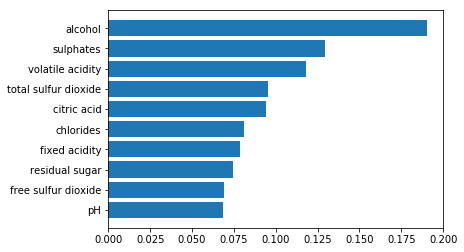

In [229]:
# identifying the most important factors.
list_importance = random_clf.feature_importances_
list_name = dfx.columns
list_importance, list_name = zip(*sorted(zip(list_importance, list_name)))
plt.barh(range(len(list_importance)),list_importance)
plt.yticks(range(len(list_name)),list_name)
plt.show()

## visualize decision surface

In [299]:
def plot_decision_surface(clf, X_train, Y_train):
    Xmin0 = X_train[:, 0].min()
    Xmin1 = X_train[:, 1].min()
    Xmax0 = X_train[:, 0].max()
    Xmax1 = X_train[:, 1].max() 
    
    plot_step_0=(Xmax0-Xmin0)/50
    plot_step_1=(Xmax1-Xmin1)/50
    
    x_min, x_max = Xmin0, Xmax0
    y_min, y_max = Xmin1, Xmax1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step_0),
                         np.arange(y_min, y_max, plot_step_1))

    clf.fit(X_train,Y_train)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
   
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.viridis,alpha=0.5)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y,cmap=plt.cm.Paired,alpha=0.5)
    plt.show()

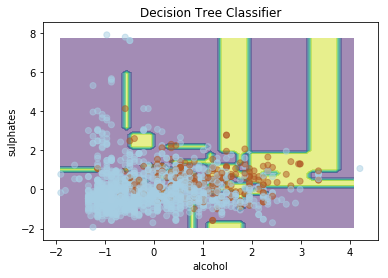

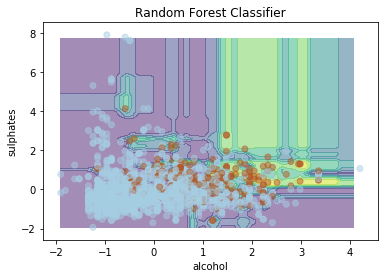

In [308]:
# 
from sklearn.tree import DecisionTreeClassifier
imp_cols = tree_clf.feature_importances_.argsort()[::-1][0:2]
X_imp = X[:,imp_cols]

classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier()]

titleClassifer = ['Decision Tree Classifier', 'Random Forest Classifier']
label_feature = dfx.columns[imp_cols].tolist()


for c in range(2):
    plt.title(titleClassifer[c])
    plt.xlabel(label_feature[0])
    plt.ylabel(label_feature[1])
    plot_decision_surface(classifiers[c], X_imp, Y)

## to do

- feature engineering: for example, ratio between alcohol and sulphate. This will require a good understanding of how chemical affect taste in a wine. 